# Similarity search - overview tutorial



__Content :__
* [Introduction](#Introduction)
    * [Task overview](#section_1_1)
    * [Usage Cases](#section_1_2)
* [Overview the data](#chapter2)
* [ANN](#ANN)
    * [Algorithm](#ANN_algo)
    * [Realisation](#ANN_realise)
    * [Time and accuracy analytics](#ANN_analyze)
    * [Saving and loading model](#ANN_save)
    * [Summary](#ANN_summ)
* [LSH](#LSH)
    * [Algorithm illustration](#LSH_algo)
    * [LSH implementation](#LSH_imp)
        * [1. Creating shingles](#shingles)
        * [2. MinHashing](#minhash)
        * [3. Buckets filling & search](#buckets)
     * [Summary](#LSH_summ)
* [Faiss](#faiss)
    * [LSH in faiss](#faiss_lsh)
    * [Inverted File Index](#faiss_ivf)
    * [Product quantisation index](#faiss_pqi)
* [Conclusion](#conclusion)
* [Further reading](#dop)
   
    

## Introduction <a class="anchor" id="Introduction"></a>


### Lets' talk about our task <a class="anchor" id="section_1_1"></a>

- __what to do?__ 
    
    We have a set of vectors, and a query vector - our task is to find the most similar vectors from our set to our query.

- __how?__ 

    This is what our tutorial is about - various interesting algorithms :)

- __why we can't simply find knn?!__ : 

    knn is good, because every time we find the most similar vector to our query (100% acccuracy). But... what if we work with big amount of data? Time complexity of O(N) is not so good, especially when we have not one query vector.

### What cases of similarity search do we know? <a class="anchor" id="section_1_2"></a>

<!-- Google images search  -->


<!-- <div>
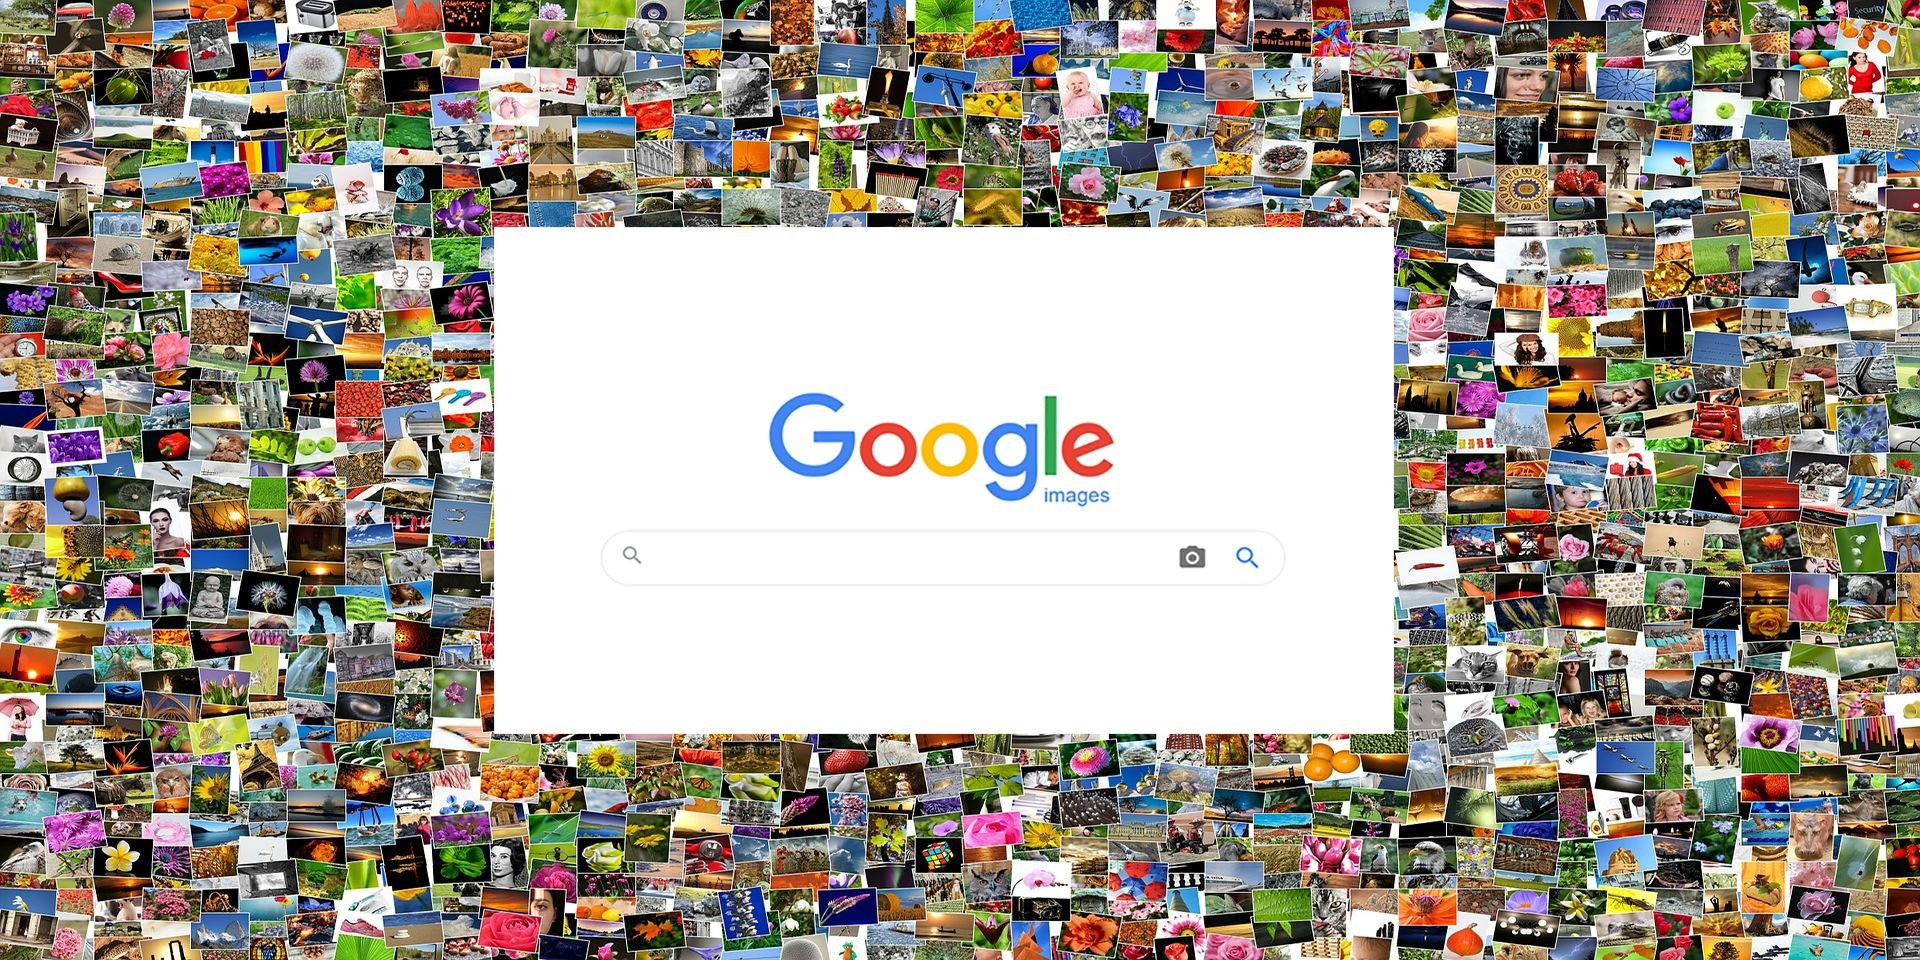
</div>
 -->

<!-- Spotify music recomendations -->


<!-- <div>
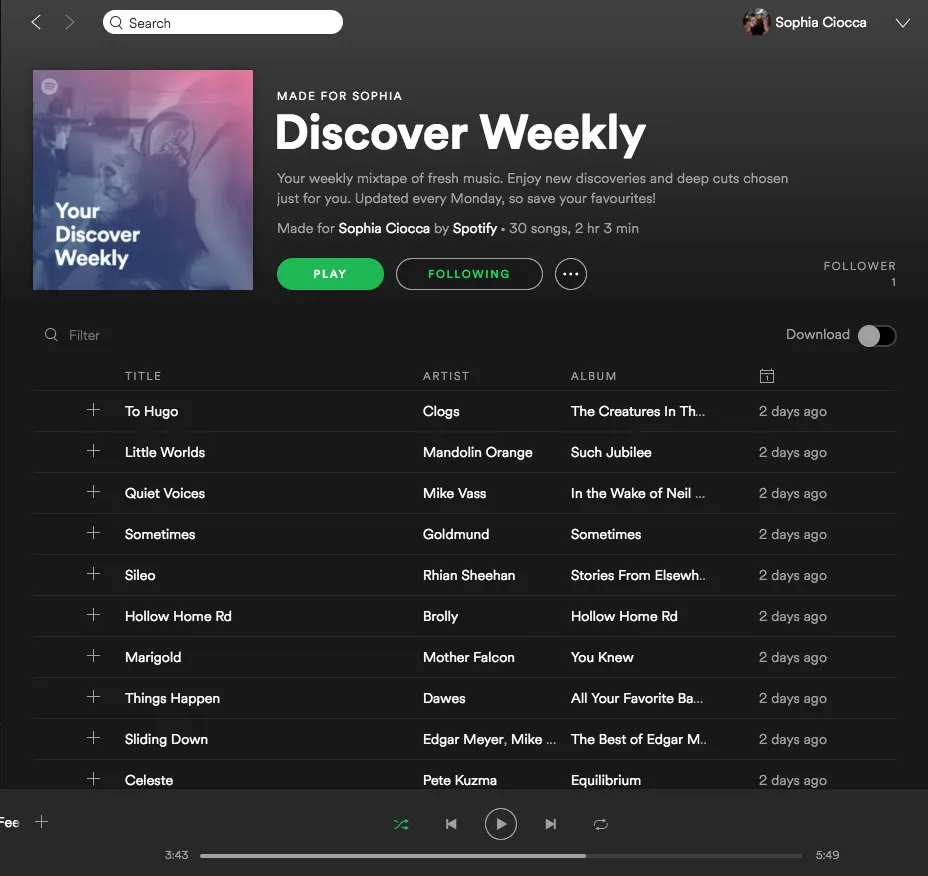
</div>
     -->

## Let's take a look at our data  <a class="anchor" id="chapter2"></a>

In [1]:
import pandas as pd
import numpy as np

In [2]:
movies = pd.read_csv('ml-25m/movies.csv') # standart movielens dataset

In [3]:
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
62418,209157,We (2018),Drama
62419,209159,Window of the Soul (2001),Documentary
62420,209163,Bad Poems (2018),Comedy|Drama
62421,209169,A Girl Thing (2001),(no genres listed)


We will make search through a movie titles. There are less than 100k vectors in our set, but here we already will see the speed gain.

_*Important point: introduced methods can also be applied in search by image6 large text etc._

In [4]:
movies.title

0                          Toy Story (1995)
1                            Jumanji (1995)
2                   Grumpier Old Men (1995)
3                  Waiting to Exhale (1995)
4        Father of the Bride Part II (1995)
                        ...                
62418                             We (2018)
62419             Window of the Soul (2001)
62420                      Bad Poems (2018)
62421                   A Girl Thing (2001)
62422        Women of Devil's Island (1962)
Name: title, Length: 62423, dtype: object

## Annoy - Approximate Nearest Neighbours Oh Yeah! <a class="anchor" id="ANN"></a>

### Let's look at algorithm: <a class="anchor" id="ANN_algo"></a>

<font size="4"> 
Step 1: Taking two random points, separating them by a hyperplane on separate regions
</font>

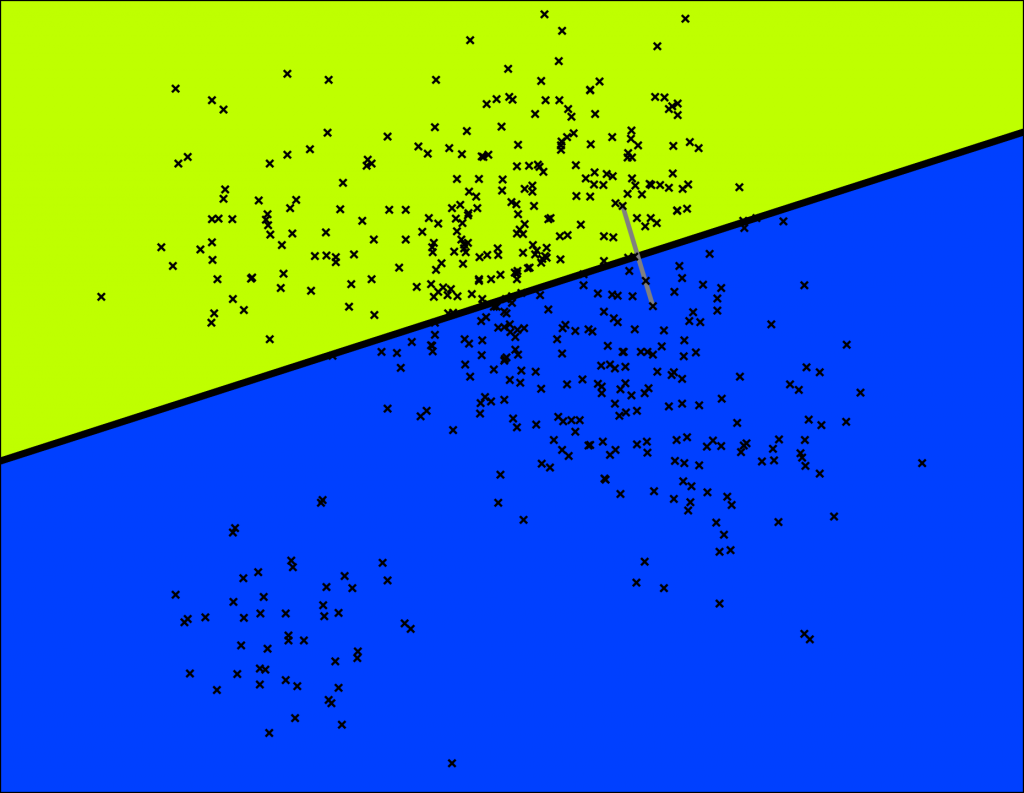 

<font size="4"> 
Step 2: Сontinue recursively splitting our regions
</font>

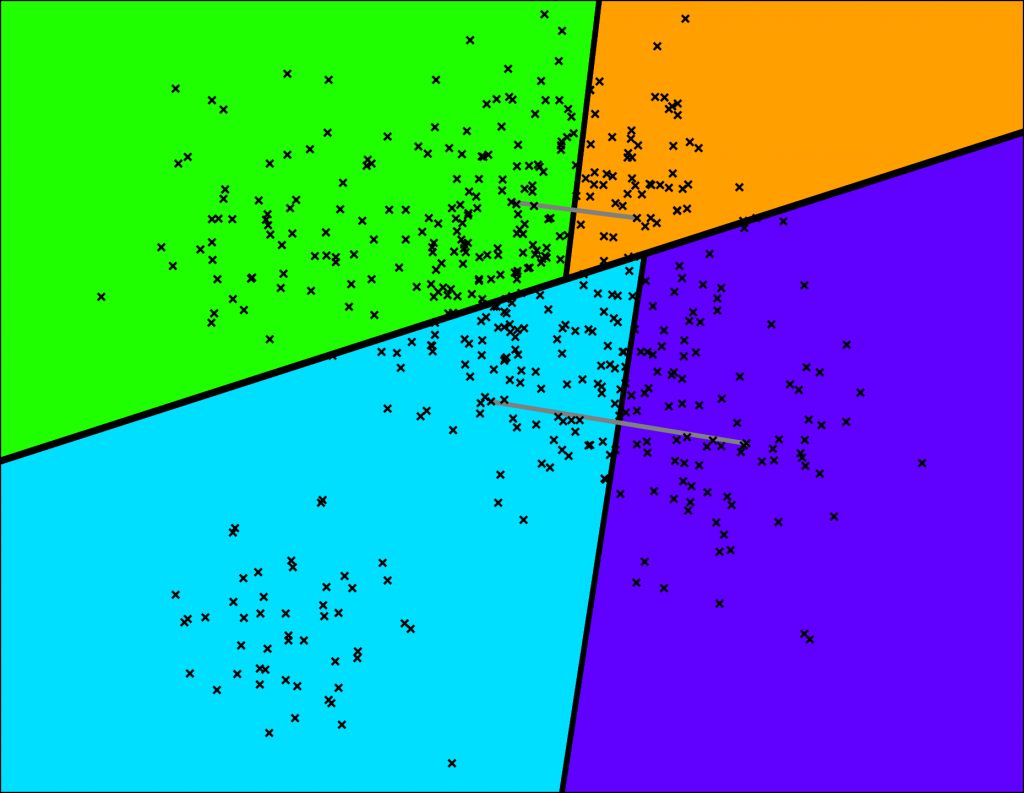

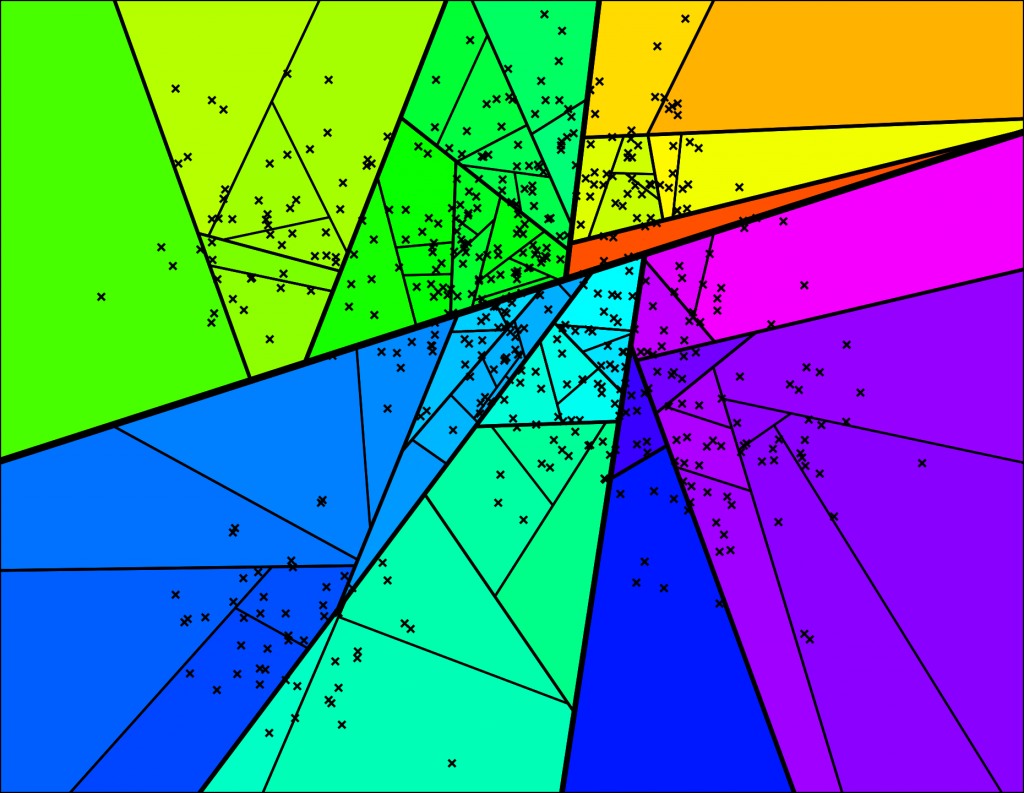

<font size="4"> 
Step 3: We know locations of all hyperplanes. So, we can find the region, where we will search for nearest neighbour.
</font>

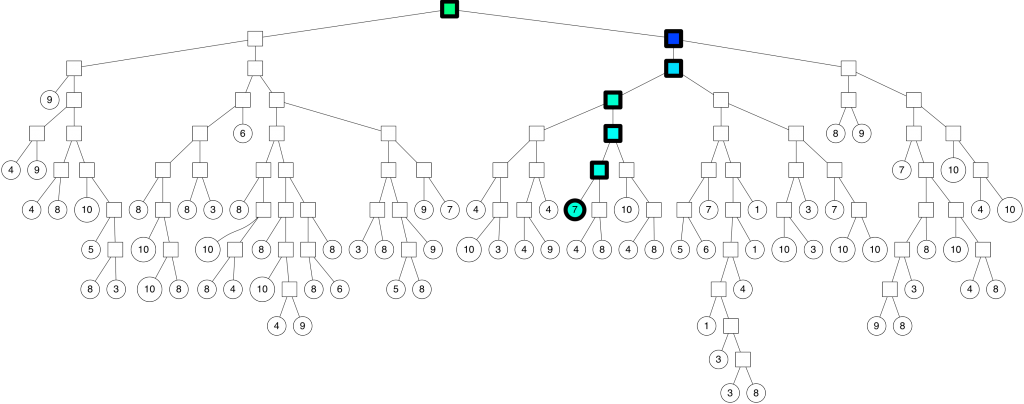

__*__ What if nearest neighbour not in query region? 
1) We can search at n nearest subregions(as you can see on picture above)
2) We can repeat splitting on a regions for a few times



### Let's look at ANN realisation <a class="anchor" id="ANN_realise"></a>

#### Firstly, we have to preprocess our titles

In [5]:
from nltk.stem.porter import PorterStemmer # for words stemming
from gensim.models import Word2Vec # for embeddings creating
import re # for text cleaning

In [6]:
stemmer = PorterStemmer() # init stememr

def preprocess(text):
    text = re.sub('[^a-zA-Z]+', ' ', text) # leave only letters
    text = text.lower().split(' ') # splitting on words
    text = [stemmer.stem(w) for w in text if w] # stem all words in sentence
    return text
    
    
    

In [7]:
data = movies['title']
data = data.apply(lambda x : preprocess(x)) #applying our func
data.head()

0                          [toy, stori]
1                             [jumanji]
2                  [grumpier, old, men]
3                     [wait, to, exhal]
4    [father, of, the, bride, part, ii]
Name: title, dtype: object

#### Now we can create an ANN indexer

In [8]:
model = Word2Vec(data, min_count=1, seed=1) # init simple word2vec model 


In [9]:
#!pip install annoy we need installed spotify annoy
from gensim.similarities.annoy import AnnoyIndexer # using inplace ANN realisation in gensim

In [10]:
%%time
annoy_index = AnnoyIndexer(model=model, num_trees=1000) 
#  model: what we want to index, 
#  num_trees: how many times we want repeat our regions splitting

CPU times: user 4min 19s, sys: 1.74 s, total: 4min 20s
Wall time: 39.1 s


In [11]:
test_words = ['cat', 'dog', 'bike', 'wrong', 'glass', 'rock', 'hit', 'clock'] # creating words for test queries

##### Standart realisation

In [12]:
for i in test_words:
    model.wv.most_similar(i, topn=10)

#####  ANN can be used in 2 different ways:

1. As parameter in wv.most_similar

In [13]:
for i in test_words:
    model.wv.most_similar(i, topn=10, indexer=annoy_index)

2. As standalone class with most_similar method

In [14]:
for i in test_words:
    annoy_index.most_similar(model.wv[i], num_neighbors=10)
    

In [15]:
annoy_index.most_similar(model.wv['cat'], num_neighbors=10)

[('great', 0.979311166331172),
 ('boy', 0.9787446334958076),
 ('face', 0.9779942650347948),
 ('sun', 0.9774504564702511),
 ('ladi', 0.9769304879009724),
 ('haunt', 0.9755925107747316),
 ('perfect', 0.9753908030688763),
 ('witch', 0.9748147334903479),
 ('wolf', 0.9747331496328115),
 ('men', 0.9737545270472765)]

In [16]:
model.wv.most_similar('cat', topn=10)

[('great', 0.9991438388824463),
 ('boy', 0.999096691608429),
 ('big', 0.9990731477737427),
 ('light', 0.9990681409835815),
 ('face', 0.9990312457084656),
 ('devil', 0.9989978671073914),
 ('wind', 0.9989844560623169),
 ('sun', 0.9989832043647766),
 ('littl', 0.9989393949508667),
 ('ladi', 0.9989355802536011)]

In [17]:
set([i[0] for i in model.wv.most_similar('cat', topn=10)]) & set([i[0] for i in annoy_index.most_similar(model.wv['cat'], num_neighbors=10)])

{'boy', 'face', 'great', 'ladi', 'sun'}

### Now let’s analyze the accuracy and initialization time depending on n_trees parameter. <a class="anchor" id="ANN_analyze"></a>

In [18]:
import time # we need time for our measurements 
from matplotlib import pyplot as plt # and plt for visualising results
plt.style.use('ggplot')

In [19]:
def get_words(q):
    '''Takes search result q, returns only words without distances'''
    return set([i[0] for i in q])

In [20]:
%%time
times =  []
accs = []

trees = list(range(100, 600, 100)) 
for t in trees:
    start = time.process_time() # start point of initialisation
    annoy_index = AnnoyIndexer(model=model, num_trees=t) # creating index with current num_trees
    t_delta = time.process_time() - start # fixing time of initialisation
    
    times.append(t_delta) # 
    
    predict = annoy_index.most_similar(model.wv['cat'], num_neighbors=25)
    predict = get_words(predict)
    
    answer = model.wv.most_similar('cat', topn=25)
    answer = get_words(answer)
    
    acc = len(answer & predict) / len(answer)

    accs.append(acc)
    


CPU times: user 6min 27s, sys: 7.35 s, total: 6min 35s
Wall time: 1min


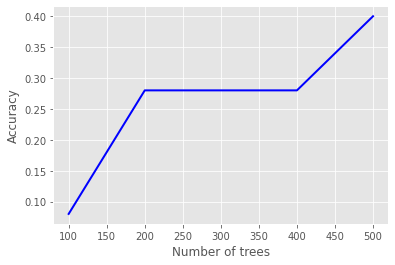

In [21]:
plt.xlabel('Number of trees')
plt.ylabel('Accuracy')
plt.plot(trees,accs, color='blue', linewidth = 2,)

plt.show()

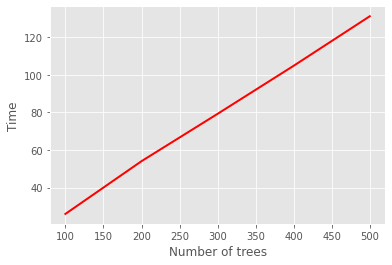

In [22]:
plt.xlabel('Number of trees')
plt.ylabel('Time')
plt.plot(trees,times, color='red', linewidth = 2);


### We can save this index and load it <a class="anchor" id="ANN_save"></a>

In [23]:
save_dir = './ANN_ind'
annoy_index.save(save_dir) # don't save the model

In [24]:
import os
# get file size
stats = os.stat(save_dir)
print('Size of file is', round(stats.st_size / 1048576), 'megabytes')

Size of file is 239 megabytes


In [25]:
new_indexer = AnnoyIndexer()
new_indexer.load(save_dir)

<font size="4"> 
Important detail : we have to provide model for loaded index
</font>

In [26]:
new_indexer.model = model

### Summary <a class="anchor" id="ANN_summ"></a>

Here we took a look on ANN algorithm and implemented it's gensim library realisation. Now, let's see pros and cons that we marked.

Prons:
* Has simple gensim built-in realisation
* Simple and interpretable algorithm

Cons:
* It has standalone realisation from spotify(annoy), but it would be more easy and efficient to use other approaches.
* Initialization time grows linearly with the number of trees, but accuracy is not


P.S. [There are many other indexes in gensim.similarities](https://radimrehurek.com/gensim/apiref.html)


## LSH - locality sensitive hashing   <a class="anchor" id="LSH_algo"></a>

### Algorithm illustration:   <a class="anchor" id="LSH_algo"></a>
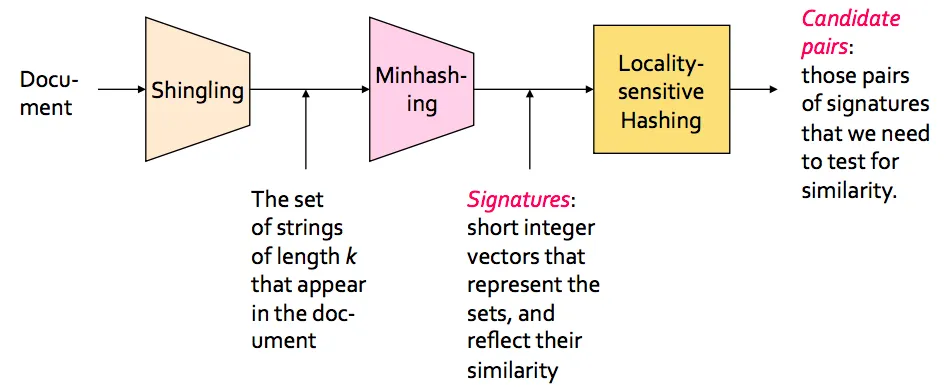

In [27]:
import numpy as np
import pandas as pd
import re
import time
import nltk

### Let's implement LSH:   <a class="anchor" id="LSH_imp"></a>


#### 1.Creating shingles    <a class="anchor" id="shingles"></a>


In [28]:
def preprocess_for_lsh(string, k):
    string = ' '.join(string) # making a list from our string
    tokens = nltk.ngrams(string, k) # making bigrams from our words
    result = [i[0] + i[1] for i in tokens] #result list of bigrams
    if len(result) == 0:
        return np.nan # if list is empty we will return nan
    return result


In [29]:
data_lsh = data.sample(100).apply(lambda x: preprocess_for_lsh(x, 3)) # here we taking a small sample of our data and do the preprocessing

In [30]:
data_lsh = data_lsh.dropna()

##### Firstly, we are doing one-hot encoding of our strings

In [31]:
def make_vocab(shingles_df):
    '''
    Func for creating all possible ngrams vocabulary
    '''
    all_vocab = []
    for el in shingles_df.values:
        all_vocab += el          # filling our vocabular
    
    return all_vocab

In [32]:
all_vocab = make_vocab(data_lsh)

In [33]:
def encode_shingles(data, vocab):
    '''
    Func for one-hot encoding our strings with our vocabulary
    '''
    encoded_df = pd.DataFrame(columns = vocab)
    for shingle in data:
        encoded_vector = [1 if w in shingle else 0 for w in all_vocab] # implement one hot encoding
        encoded_df.loc[len(encoded_df)] = encoded_vector
    
    encoded_df.index = data.index
    return encoded_df
    
    

In [34]:
encoded_df = encode_shingles(data_lsh, all_vocab)

In [35]:
encoded_df.T.head()


,4921,28481,19136,16783,13533,53034,8475,802,35443,28295,...,11300,15899,56748,27108,62060,1177,23905,40568,44246,41497
an,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
no,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
ot,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
th,1,1,0,1,0,0,1,1,1,0,...,1,1,0,0,0,0,0,0,1,1
h,1,0,0,1,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1


#### 2.MinHashing    <a class="anchor" id="minhash"></a>


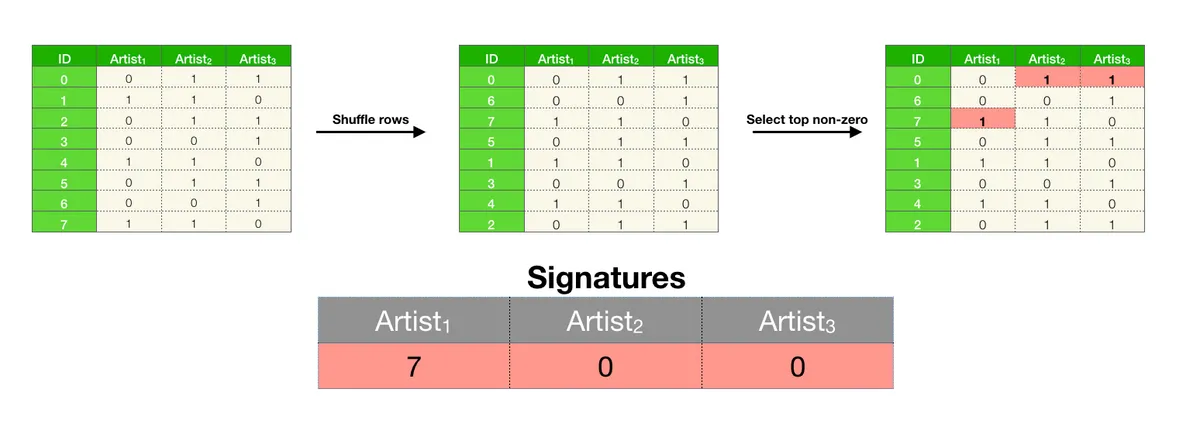

In [36]:
# for minhashing we need a permutation of our encoded vector
perm = encoded_df.T.sample(frac=1)
perm

,4921,28481,19136,16783,13533,53034,8475,802,35443,28295,...,11300,15899,56748,27108,62060,1177,23905,40568,44246,41497
no,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
or,0,0,0,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1
wi,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pr,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
en,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
f,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
e,0,1,1,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,1,1
si,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
om,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [37]:
def min_ind_row(x):
    '''
    With this function we can get minimuum index of 1 in encoded vector 
    '''
    return np.min(np.where(x == 1))

def make_MinHash(data):
    '''
    With this function, we can apply min_ind_row() to every row of our dataframe.
    By this, we get MinHashes of every row
    '''
    hashes = np.apply_along_axis(min_ind_row, axis=0, arr=data.values) # take min index of 1 in our permutation
    return dict(zip(data.columns, hashes))

In [38]:
num_permutations = 100 # setting number of permutations
min_hash_list = [] # here we will place MinHashing results
for i in range(num_permutations):
    perm = encoded_df.T.sample(frac=1) # making a permutation
    min_hash_list.append(make_MinHash(perm)) # append minhashing result

In [39]:
signatures = pd.DataFrame(min_hash_list)
signatures.head()

,4921,28481,19136,16783,13533,53034,8475,802,35443,28295,...,11300,15899,56748,27108,62060,1177,23905,40568,44246,41497
0,38,7,5,7,13,10,14,5,2,7,...,2,13,7,10,31,18,54,74,36,2
1,30,7,1,22,12,4,25,1,0,20,...,12,9,82,8,57,2,2,11,11,3
2,0,0,3,0,32,20,0,0,0,7,...,0,0,54,2,23,11,19,13,0,0
3,25,0,12,2,12,22,0,1,7,40,...,4,25,23,15,47,35,34,18,11,1
4,2,3,1,4,26,20,8,3,2,5,...,10,14,5,0,8,20,7,15,3,2


##### let's compare similarities of signatures with similarities of original vectors

In [40]:
from sklearn.metrics import jaccard_score


In [41]:
# checking similarities of our signatures 
for i in signatures.columns:
    for j in signatures.columns:
        if i != j and jaccard_score(encoded_df.T[i], encoded_df.T[j]) > 0.3:
            c_1 = i
            c_2 = j
            break

In [42]:
print(jaccard_score(encoded_df.T[c_1], encoded_df.T[c_2]))


0.3006896551724138


In [43]:
def get_distance(col1, col2, df):

    similarity_count = df[col1]==df[col2]
    similarity_count = similarity_count.sum(0)

    return (similarity_count /len(list(df.index)))

In [44]:
from sklearn.metrics import jaccard_score
get_distance(c_1, c_2, signatures)

0.26

#### 3.Buckets filling & search    <a class="anchor" id="buckets"></a>

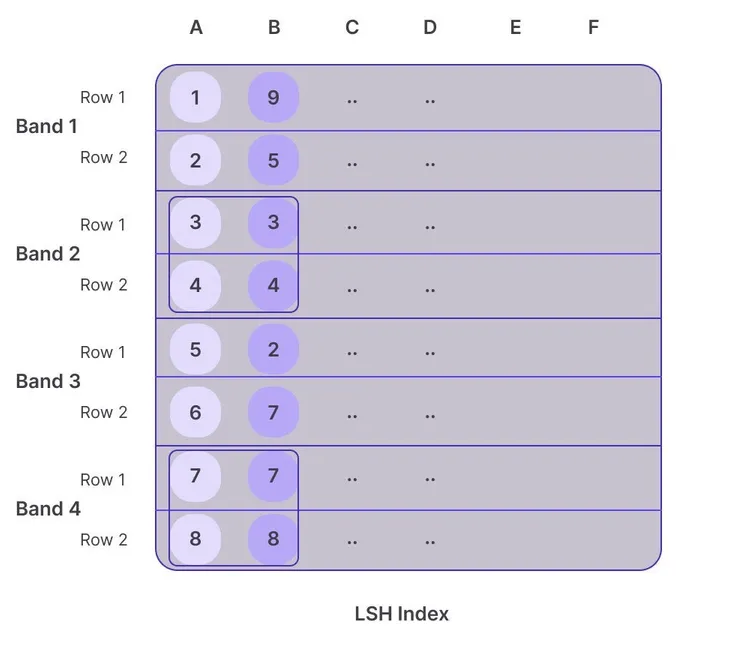

In [45]:
signatures

,4921,28481,19136,16783,13533,53034,8475,802,35443,28295,...,11300,15899,56748,27108,62060,1177,23905,40568,44246,41497
0,38,7,5,7,13,10,14,5,2,7,...,2,13,7,10,31,18,54,74,36,2
1,30,7,1,22,12,4,25,1,0,20,...,12,9,82,8,57,2,2,11,11,3
2,0,0,3,0,32,20,0,0,0,7,...,0,0,54,2,23,11,19,13,0,0
3,25,0,12,2,12,22,0,1,7,40,...,4,25,23,15,47,35,34,18,11,1
4,2,3,1,4,26,20,8,3,2,5,...,10,14,5,0,8,20,7,15,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,18,8,3,5,0,3,20,9,5,52,...,24,8,10,8,3,47,7,31,28,3
96,49,0,3,0,1,39,3,3,2,0,...,3,3,0,22,14,31,4,1,13,2
97,14,0,0,3,19,44,14,0,14,5,...,0,14,5,38,96,54,30,88,0,0
98,23,0,1,6,0,1,0,9,0,39,...,3,4,37,26,1,4,5,55,7,1


In [46]:
r = 4
b = int(signatures.shape[0] / r)

In [47]:
v_1 = signatures[c_1].values
v_1 = np.array_split(v_1, b, axis=0)


In [48]:
for number in signatures.columns[1:]:
    test_vec = signatures[number].values
    test_vec = np.array_split(test_vec, b, axis=0)
    for i in range(b):
        if np.array_equal(v_1[i], test_vec[i]):
            print(f'{number}  is a candidate!')
            break


802  is a candidate!
35443  is a candidate!
15087  is a candidate!
52598  is a candidate!
14241  is a candidate!
5873  is a candidate!
33305  is a candidate!
22411  is a candidate!
58227  is a candidate!
62014  is a candidate!
11300  is a candidate!
41497  is a candidate!


### Summary <a class="anchor" id="LSH_summ"></a>

In this part, we created a simple, but not so efficient, LSH realisation. However, now we understand all key concepts that this method is based on.

Let's summarise:

Prons:
* Built-in dimensionality reduction
* Small amount of false negatives for similar vectors

Cons:
* Not so easy to interpet 
* Very sensitive to parameters selection (also hash functions)
* Use a lot of memory



## Faiss    <a class="anchor" id="faiss"></a>

Facebook AI similarity search is an efficient library for index creating and using. There we can find not only introduced indexes, but much more.

In [49]:
# we have to separate realisation for gpu and cpu
!pip install faiss-cpu
# !pip install faiss-gpu


In [50]:
import faiss  

### LSH in faiss <a class="anchor" id="faiss_lsh"></a>

In [51]:
# let's look at our df another time
encoded_df.head()

,an,no,ot,th,h,h,th,he,e,f,...,s,s,h,ha,ai,ir,rb,br,ru,us
4921,1,1,1,1,1,1,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
28481,0,0,0,1,0,0,1,1,1,1,...,1,0,0,0,0,0,0,0,0,0
19136,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
16783,0,0,0,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13533,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


##### How it works in Faiss?

1. We convert our vectors to binary representations
2. Compare hamming distances

_*Hamming distance is the number of positions at which the corresponding symbols are different._
<div>
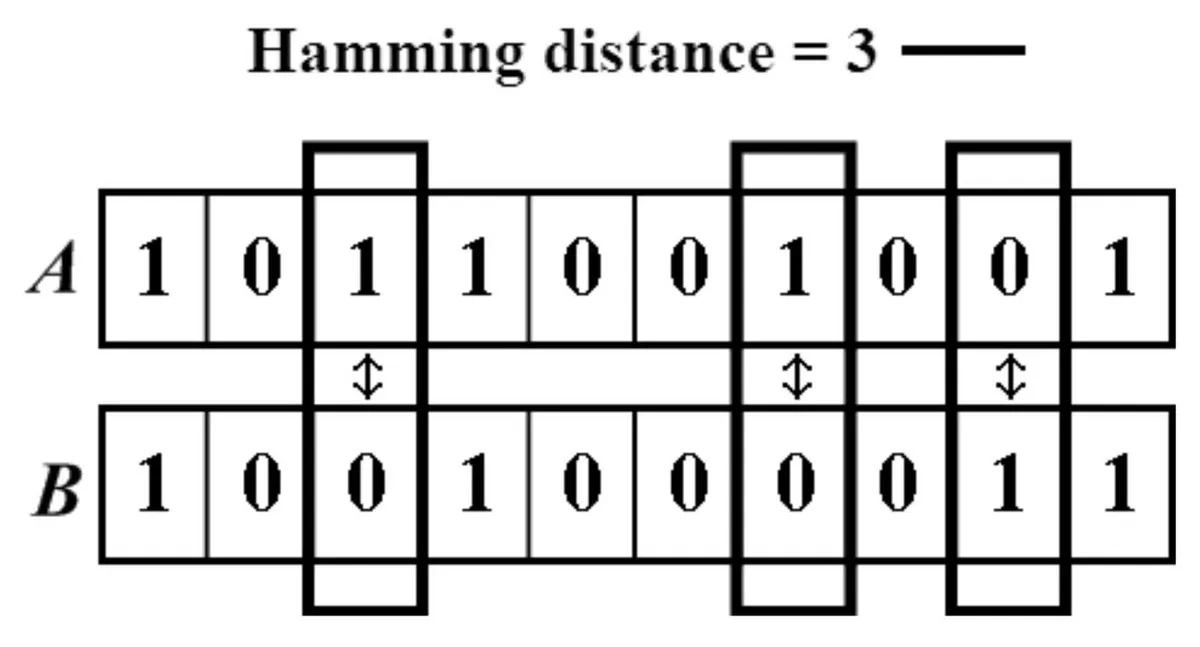
</div>


In [52]:
nbits = 2 * encoded_df.shape[1] # detalisation parameter
dimension = encoded_df.shape[1] # dimension of our vectors

LSH = faiss.IndexLSH(dimension, nbits)


In [53]:
LSH.is_trained # we don't need to train it - just put in vectors that we want to store

True

In [54]:
try:
    LSH.add(encoded_df.values)
except ValueError:
    print('something wrong with values!')

something wrong with values!


In [55]:
stored_vectors = encoded_df.values.astype('float32')

In [56]:
np.ascontiguousarray(stored_vectors)

array([[1., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 1., ..., 1., 1., 1.]], dtype=float32)

In [57]:
LSH.add(np.ascontiguousarray(stored_vectors))

In [58]:
query = np.ascontiguousarray(encoded_df.loc[c_1].values.astype('float32'))

In [59]:
try:
    dists, indexes = LSH.search(query, 5)
except ValueError:
    print('something wrong with values! another time!')

something wrong with values! another time!


In [60]:
query.shape

(1554,)

In [61]:
dists, indexes = LSH.search(query.reshape(1, dimension), 5)


In [62]:
encoded_df.iloc[indexes[0]]

,an,no,ot,th,h,h,th,he,e,f,...,s,s,h,ha,ai,ir,rb,br,ru,us
41497,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
52598,0,0,1,1,0,0,1,1,1,0,...,1,0,0,0,0,0,0,0,0,1
15087,1,0,0,1,0,0,1,1,1,0,...,1,0,0,0,0,0,0,0,0,0
55998,0,1,0,1,0,1,1,1,1,1,...,0,0,1,0,0,0,0,0,0,0
802,0,0,0,1,1,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0


#### Let's explore other Faiss indexes !

### InVertedFileIndex(IVF) <a class="anchor" id="faiss_ivf"></a>

The idea behind this method is similar to ANN, but we do not use huperplanes. Instead of them, we split our dimension by setting clusters.

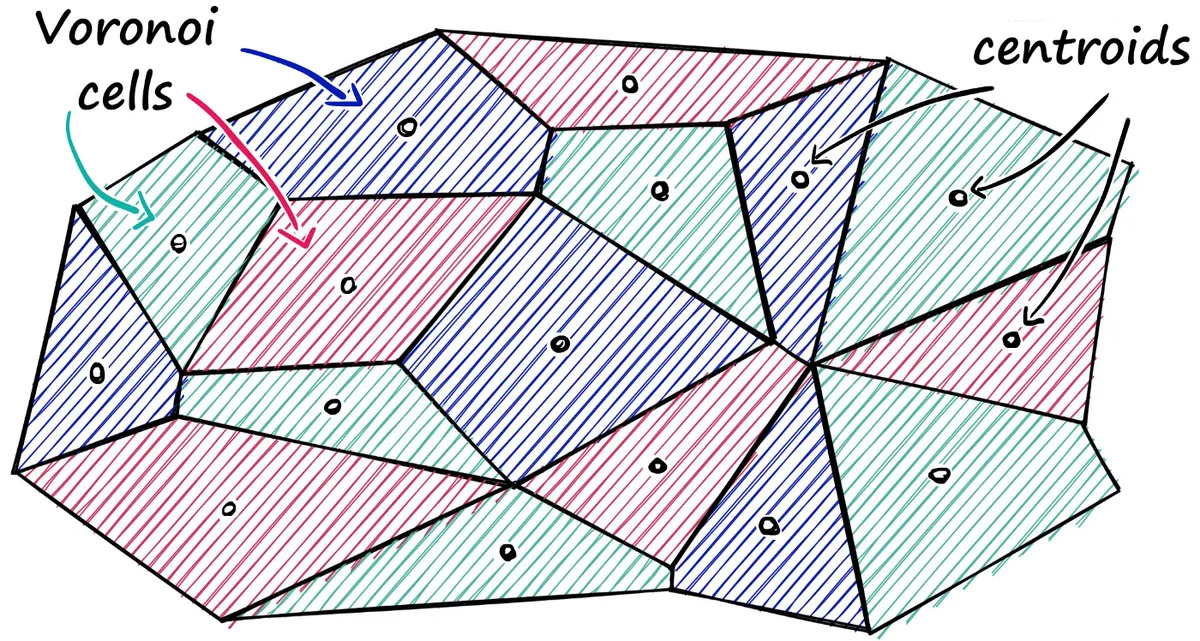

In [63]:
np.random.seed(1)             
stored_vectors = np.random.random((10_000, 256)).astype('float32') # make new dataset

In [64]:
dimension = stored_vectors.shape[1]   # dimensions of each vector                         
n = stored_vectors.shape[0]   # number of vectors                   

In [65]:
nlist = 50  # number of our cells

comparator = faiss.IndexFlatL2(dimension)  # index for comparing vectors within one cell
index = faiss.IndexIVFFlat(comparator, dimension, nlist)


In [66]:
comparator.is_trained 

True

In [67]:
index.is_trained 

False

In [68]:
index.train(stored_vectors)  # we must train index to get our cells
index.add(stored_vectors)


In [69]:
index.nprobe = 20  # how many nearest cells we will search


In [70]:
k = 100 # how much nearest neighbours do we need

In [71]:
query = np.random.random((1, dimension)).astype('float32')

In [72]:
%%time
dists, inds = index.search(query, k)

CPU times: user 861 µs, sys: 671 µs, total: 1.53 ms
Wall time: 492 µs


In [73]:
dists, inds = index.search(query, k)

In [74]:
dists, inds

(array([[31.87514 , 31.89427 , 32.564922, 32.717735, 32.9433  , 33.11295 ,
         33.12267 , 33.222366, 33.27481 , 33.309547, 33.369717, 33.476967,
         33.5262  , 33.55802 , 33.819664, 33.822536, 33.83818 , 33.955845,
         34.017128, 34.13944 , 34.296333, 34.3079  , 34.32244 , 34.39051 ,
         34.42661 , 34.445263, 34.447285, 34.450897, 34.49495 , 34.499023,
         34.50187 , 34.546192, 34.572235, 34.58792 , 34.610695, 34.66225 ,
         34.710102, 34.71179 , 34.74295 , 34.744137, 34.80679 , 34.839302,
         34.910484, 34.944714, 35.035835, 35.037247, 35.06391 , 35.109764,
         35.119125, 35.12529 , 35.133095, 35.13703 , 35.15056 , 35.16174 ,
         35.189476, 35.249496, 35.254025, 35.258827, 35.286392, 35.29506 ,
         35.30709 , 35.30876 , 35.313133, 35.356075, 35.367126, 35.39074 ,
         35.42227 , 35.426796, 35.43215 , 35.43592 , 35.469307, 35.496456,
         35.518417, 35.54689 , 35.553375, 35.578773, 35.593124, 35.600807,
         35.64508 , 35.64

#### Also we can measure our recall - we know that L2 index gives us the best result

In [75]:
comparator.add(stored_vectors)


In [76]:
%%time
l2_dists, l2_inds = comparator.search(query, k)

CPU times: user 1.12 ms, sys: 748 µs, total: 1.87 ms
Wall time: 996 µs


In [77]:
l2_dists, l2_inds = comparator.search(query, k)

In [78]:
sum([1 if i in l2_inds else 0 for i in inds]) / k

0.0

In [79]:
l2_dists, l2_inds

(array([[19.497143, 20.531708, 20.848   , 20.900856, 20.901478, 20.936623,
         20.957516, 20.964928, 20.995224, 21.023926, 21.036173, 21.140541,
         21.241888, 21.458288, 21.46204 , 21.482643, 21.556225, 21.570328,
         21.589752, 21.60281 , 21.638988, 21.66613 , 21.679668, 21.714167,
         21.716526, 21.74957 , 21.75012 , 21.756285, 21.757372, 21.791836,
         21.808483, 21.854982, 21.920898, 21.922344, 21.92345 , 21.92773 ,
         21.928547, 21.980602, 21.983257, 21.993746, 22.009373, 22.052357,
         22.109615, 22.131092, 22.20108 , 22.354073, 22.635845, 22.861351,
         23.802269, 25.127613, 31.87514 , 31.89427 , 32.034405, 32.564922,
         32.717735, 32.771908, 32.9433  , 33.04562 , 33.11295 , 33.12267 ,
         33.222366, 33.27481 , 33.309547, 33.369717, 33.476967, 33.5262  ,
         33.55802 , 33.656906, 33.819664, 33.822536, 33.83818 , 33.903492,
         33.955845, 34.017128, 34.107925, 34.13944 , 34.188934, 34.216827,
         34.296333, 34.30

In [80]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(l2_dists, dists)

7.0598965

### Product quantisation index <a class="anchor" id="faiss_pqi"></a>

How is PQ works?
1. We split every our vector on m subvectors.
2. Making clusters from this subvectors.
3. Replace every subvector by it's cluster id.

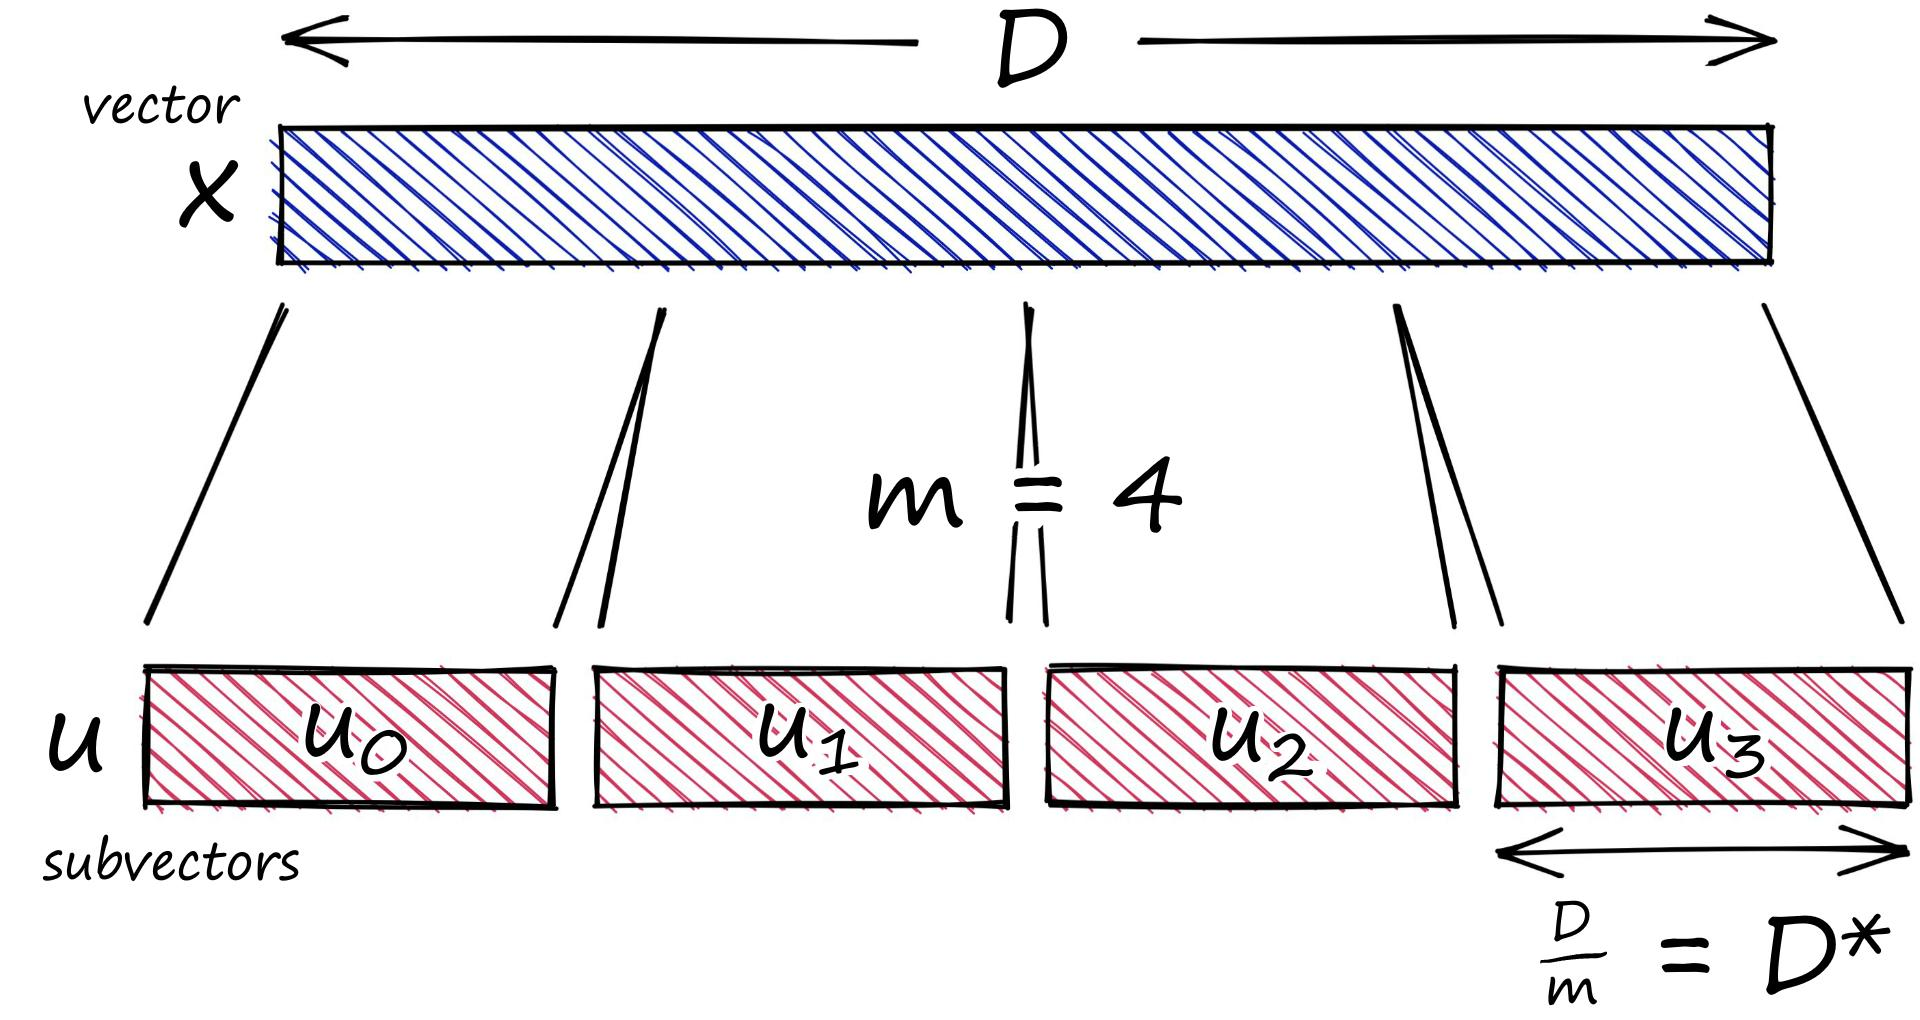

In [81]:
import faiss
m = 8
assert dimension % m == 0
nbits = 8  # number of bits per subquantizer, k* = 2**nbits
index = faiss.IndexPQ(dimension, m, nbits)

In [82]:
index.is_trained 

False

In [83]:
index.train(stored_vectors)  # we must train index to get our cells
index.add(stored_vectors)


In [84]:
%%timeit
dists, inds = index.search(query, k)

289 µs ± 28.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [85]:
dists, inds = index.search(query, k)

In [86]:
dists, inds

(array([[21.987106, 22.264006, 22.274113, 22.442318, 22.811277, 22.812447,
         22.882275, 22.925785, 22.981537, 23.002848, 23.026714, 23.05658 ,
         23.182653, 23.18565 , 23.186132, 23.194962, 23.199795, 23.237312,
         23.251595, 23.252735, 23.261177, 23.265144, 23.267544, 23.294563,
         23.304808, 23.31211 , 23.32721 , 23.3314  , 23.349644, 23.376358,
         23.376934, 23.381653, 23.39656 , 23.399124, 23.415327, 23.432463,
         23.462347, 23.466026, 23.482256, 23.494862, 23.503126, 23.524403,
         23.536175, 23.541832, 23.544544, 23.56248 , 23.57713 , 23.585485,
         23.592028, 23.59942 , 23.629253, 23.63286 , 23.651836, 23.655615,
         23.658653, 23.675161, 23.677235, 23.677675, 23.681732, 23.684364,
         23.684967, 23.699633, 23.701347, 23.70823 , 23.710522, 23.71436 ,
         23.714884, 23.729599, 23.732737, 23.755047, 23.764217, 23.76852 ,
         23.769499, 23.775967, 23.777925, 23.783066, 23.80091 , 23.802732,
         23.803429, 23.81

In [87]:
np.linalg.norm(stored_vectors[3865] - query)

6.260585

In [88]:
np.linalg.norm(stored_vectors[96] - query)

6.8163695

In [89]:
sum([1 if i in l2_inds else 0 for i in inds]) / k

0.01

In [90]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(l2_dists, dists)

5.8272796

## Conclusion <a class="anchor" id="conclusion"></a>

In this tutorial, we reviewed one of the most popular, and efficient algorithms for solving similarity search problems.

Now we know:
* how we can solve the search problem for embeddings obtainded using the gensim library.

* how Locality Sensitive Hashing works and how we can decrease the dimensionality of our vectors using MinHash.

* how to apply the considered algorithms most effectively using Faiss.

##### This tutorial is based on open courses and lectures on similarity search. If you want to dive deeper, you can start with these materials:    <a class="anchor" id="dop"></a>

* [Usefull articles about similarity search and nlp](https://www.pinecone.io/learn/)
* [Lections about theory behind algorithms](https://www.youtube.com/channel/UC_Oao2FYkLAUlUVkBfze4jg/videos)
* [Example of bulding recsys with LSH](https://www.learndatasci.com/tutorials/building-recommendation-engine-locality-sensitive-hashing-lsh-python/) 
* [How to choose correct index? Faiss guidline](https://github.com/facebookresearch/faiss/wiki/Guidelines-to-choose-an-index)
